# Ridge Analysis

## Imports

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import sys
from pathlib import Path
import importlib

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler



# fix file path
sys.path.append(str(Path("..").resolve()))

from Implementations import prepare_data
importlib.reload(prepare_data)

from Implementations.prepare_data import prepare_data

from Implementations import plot_style
importlib.reload(plot_style)
from Implementations.plot_style import set_latex_style, fig_ax, save_pdf




### Fetching data

In [6]:
df = pd.read_csv("../Data_Processed/player_core_features.csv")

data = prepare_data(df, test_size=0.2, seed=6114)
print(data["summary"])

X_train = data["X_train"]
X_test  = data["X_test"]
y_train = data["ylog_train"].ravel()
y_test  = data["ylog_test"].ravel()

feature_cols = data["feature_cols"]
groups_full = data["groups_full"]


{'n_rows_total': 278558, 'n_rows_used': 275230, 'n_features': 24, 'test_size': 0.2, 'seed': 6114, 'numeric_only': True, 'drop_na': True, 'standardize': True, 'player_overlap_train_test': 0}


### Ridge Baseline

In [7]:
lam = 1.0
ridge = Ridge(alpha=lam)  # Baseline, arbitrary lambda
ridge.fit(X_train, y_train)

pred_test = ridge.predict(X_test)
mse = mean_squared_error(y_test, pred_test)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, pred_test)

print(f"Ridge(lambda={lam}) | RMSE(log)={rmse:.4f} | R2(log)={r2:.4f}")


Ridge(lambda=1.0) | RMSE(log)=1.0631 | R2(log)=0.5060


### K-fold (group) cross validation

/Users/adnerolstad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning: Ill-conditioned matrix (rcond=2.26333e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/Users/adnerolstad/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning: Ill-conditioned matrix (rcond=1.79517e-08): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Best lambda (GroupKFold on TRAIN): 1.778e+02 | CV RMSE(log)=1.0792


'../Plots/fig_ridge_core_lambda.pdf'

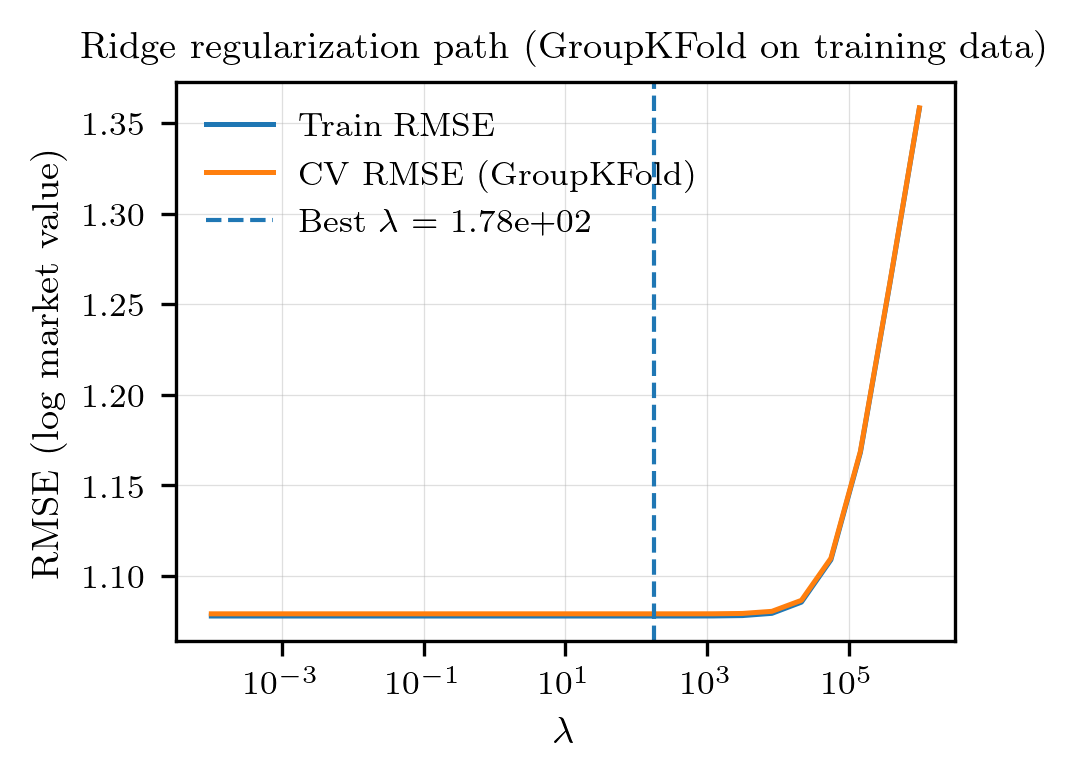

In [9]:
X_tr = data["X_train"]
y_tr = data["ylog_train"].ravel()
groups_tr = data["groups_train"]

lambdas = np.logspace(-4, 6, 25)  # test 25 different lambdas, log-spaced
gkf = GroupKFold(n_splits=5)

train_rmse = []
val_rmse = []

for lam in lambdas:
    rmse_tr_folds = []
    rmse_va_folds = []

    for tr_idx, va_idx in gkf.split(X_tr, y_tr, groups=groups_tr):
        model = Ridge(alpha=lam)
        model.fit(X_tr[tr_idx], y_tr[tr_idx])
        
        pred_tr = model.predict(X_tr[tr_idx])
        pred_va = model.predict(X_tr[va_idx])

        rmse_tr_folds.append(np.sqrt(mean_squared_error(y_tr[tr_idx], pred_tr)))
        rmse_va_folds.append(np.sqrt(mean_squared_error(y_tr[va_idx], pred_va)))

    train_rmse.append(np.mean(rmse_tr_folds))
    val_rmse.append(np.mean(rmse_va_folds))

best_i = int(np.argmin(val_rmse))
best_lambda = lambdas[best_i]

print(f"Best lambda (GroupKFold on TRAIN): {best_lambda:.3e} | CV RMSE(log)={val_rmse[best_i]:.4f}")

# --- Plot using plot_style ---
set_latex_style(usetex=True)

fig, ax = fig_ax("onecol", height_scale=1.1)

ax.plot(lambdas, train_rmse, label=r"Train RMSE", linewidth=1.2)
ax.plot(lambdas, val_rmse, label=r"CV RMSE (GroupKFold)", linewidth=1.2)
ax.axvline(best_lambda, linestyle="--", linewidth=1.0,
           label=rf"Best $\lambda$ = {best_lambda:.2e}")

ax.set_xscale("log")
ax.set_xlabel(r"$\lambda$")
ax.set_ylabel(r"RMSE (log market value)")
ax.set_title(r"Ridge regularization path (GroupKFold on training data)")

ax.legend(frameon=False, loc="best")
ax.grid(True, which="both", linewidth=0.3, alpha=0.4)

save_pdf(fig, "fig_ridge_core_lambda.pdf", folder="../Plots")



### Ridge model, optimal lambda

In [10]:
ridge_best = Ridge(alpha=best_lambda)
ridge_best.fit(data["X_train"], data["ylog_train"].ravel())

pred_test = ridge_best.predict(data["X_test"])
mse_test = mean_squared_error(data["ylog_test"].ravel(), pred_test)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(data["ylog_test"].ravel(), pred_test)

print(f"Ridge(best alpha={best_lambda:.2e}) | RMSE(log)={rmse_test:.4f} | R2(log)={r2_test:.4f}")


Ridge(best alpha=1.78e+02) | RMSE(log)=1.0631 | R2(log)=0.5059


### Plotting results

'../Plots/fig_ridge_core_residuals.pdf'

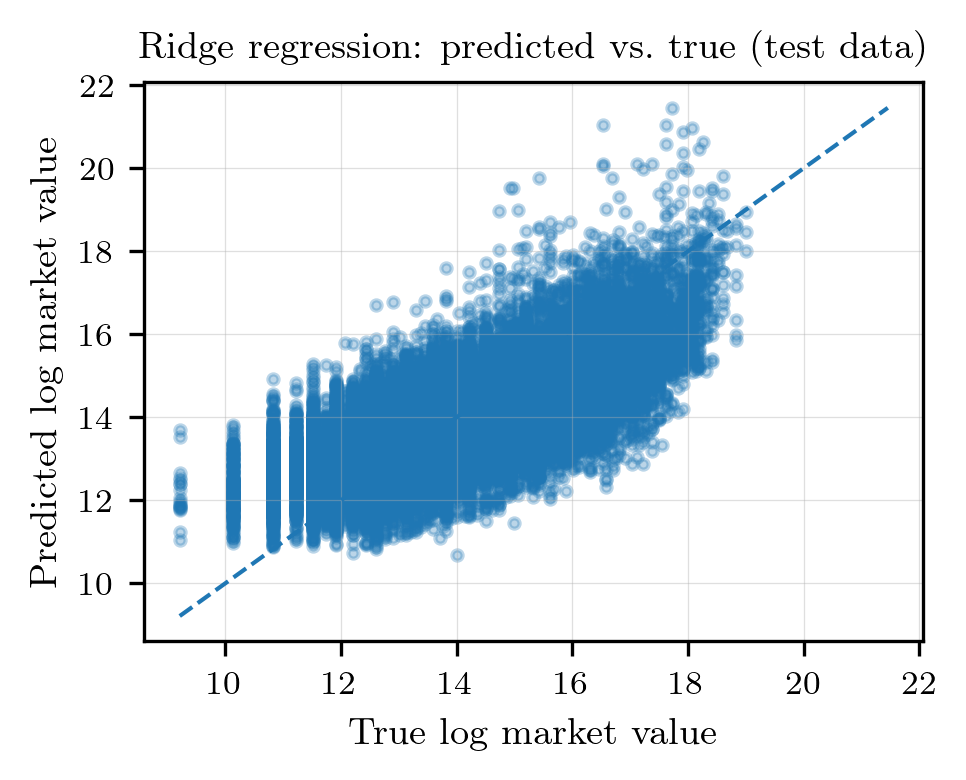

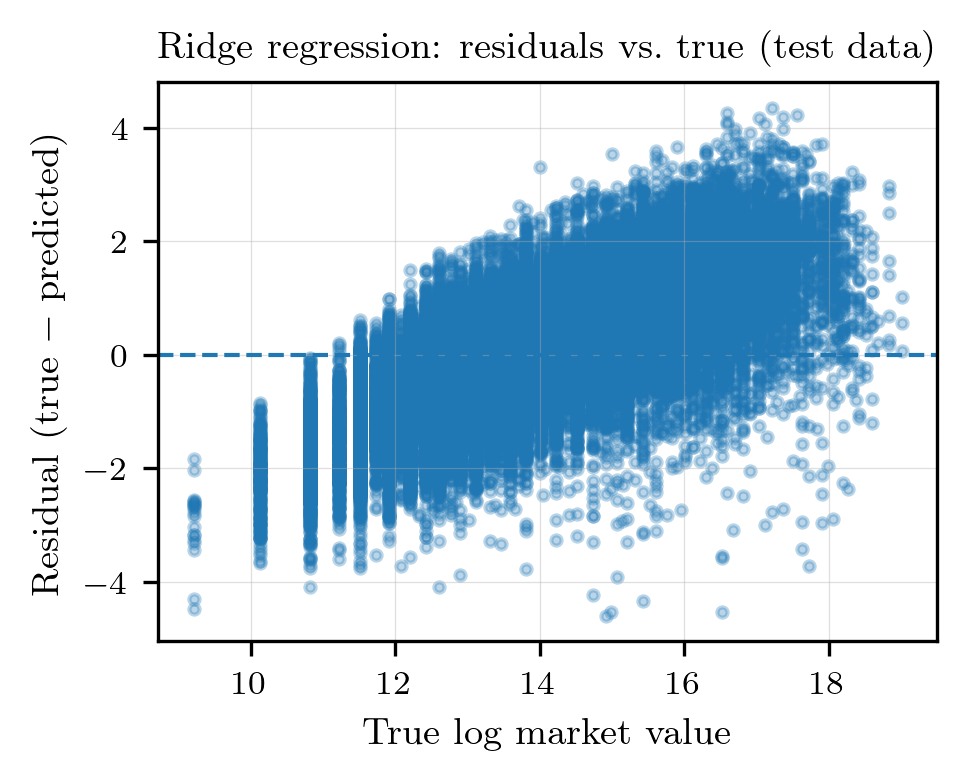

In [11]:
pred = ridge_best.predict(X_test)
residuals = y_test - pred


### Pred vs True
set_latex_style(usetex=True)

fig, ax = fig_ax("onecol", height_scale=1.1)

ax.scatter(y_test, pred, s=6, alpha=0.3)
mn = min(y_test.min(), pred.min())
mx = max(y_test.max(), pred.max())
ax.plot([mn, mx], [mn, mx], linestyle="--", linewidth=1.0)

ax.set_xlabel(r"True log market value")
ax.set_ylabel(r"Predicted log market value")
ax.set_title(r"Ridge regression: predicted vs.\ true (test data)")

ax.grid(True, which="both", linewidth=0.3, alpha=0.4)

save_pdf(fig, "fig_ridge_core_pred_vs_true.pdf", folder="../Plots")



### Residuals vs true
set_latex_style(usetex=True)

fig, ax = fig_ax("onecol", height_scale=1.1)

ax.scatter(y_test, residuals, s=6, alpha=0.3)
ax.axhline(0.0, linestyle="--", linewidth=1.0)

ax.set_xlabel(r"True log market value")
ax.set_ylabel(r"Residual (true $-$ predicted)")
ax.set_title(r"Ridge regression: residuals vs.\ true (test data)")

ax.grid(True, which="both", linewidth=0.3, alpha=0.4)

save_pdf(fig, "fig_ridge_core_residuals.pdf", folder="../Plots")


### Plotting/Presenting the Coefficients

'../Plots/fig_ridge_core_top_negative_coefficients.pdf'

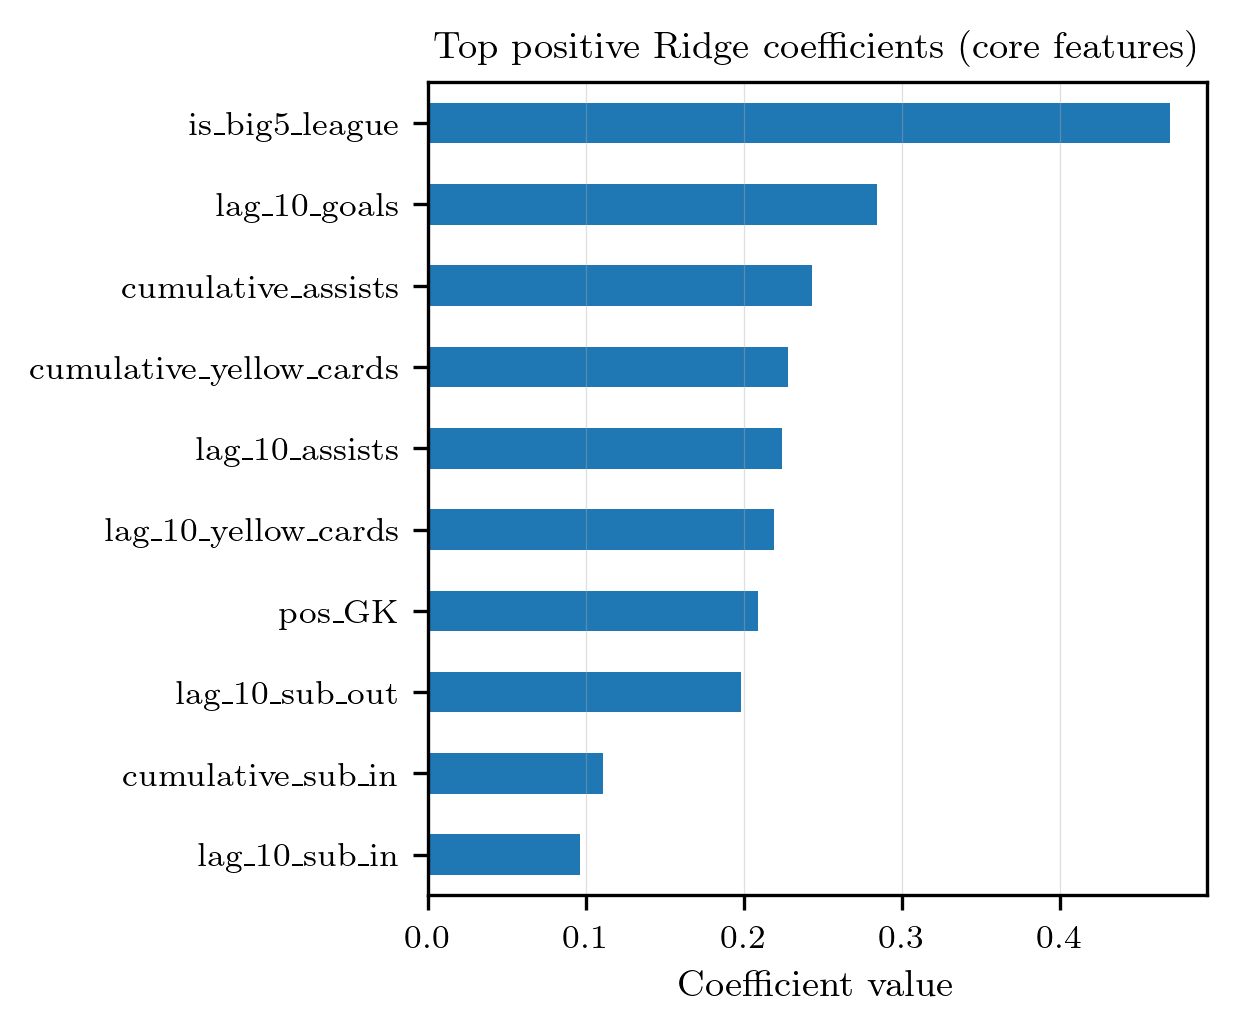

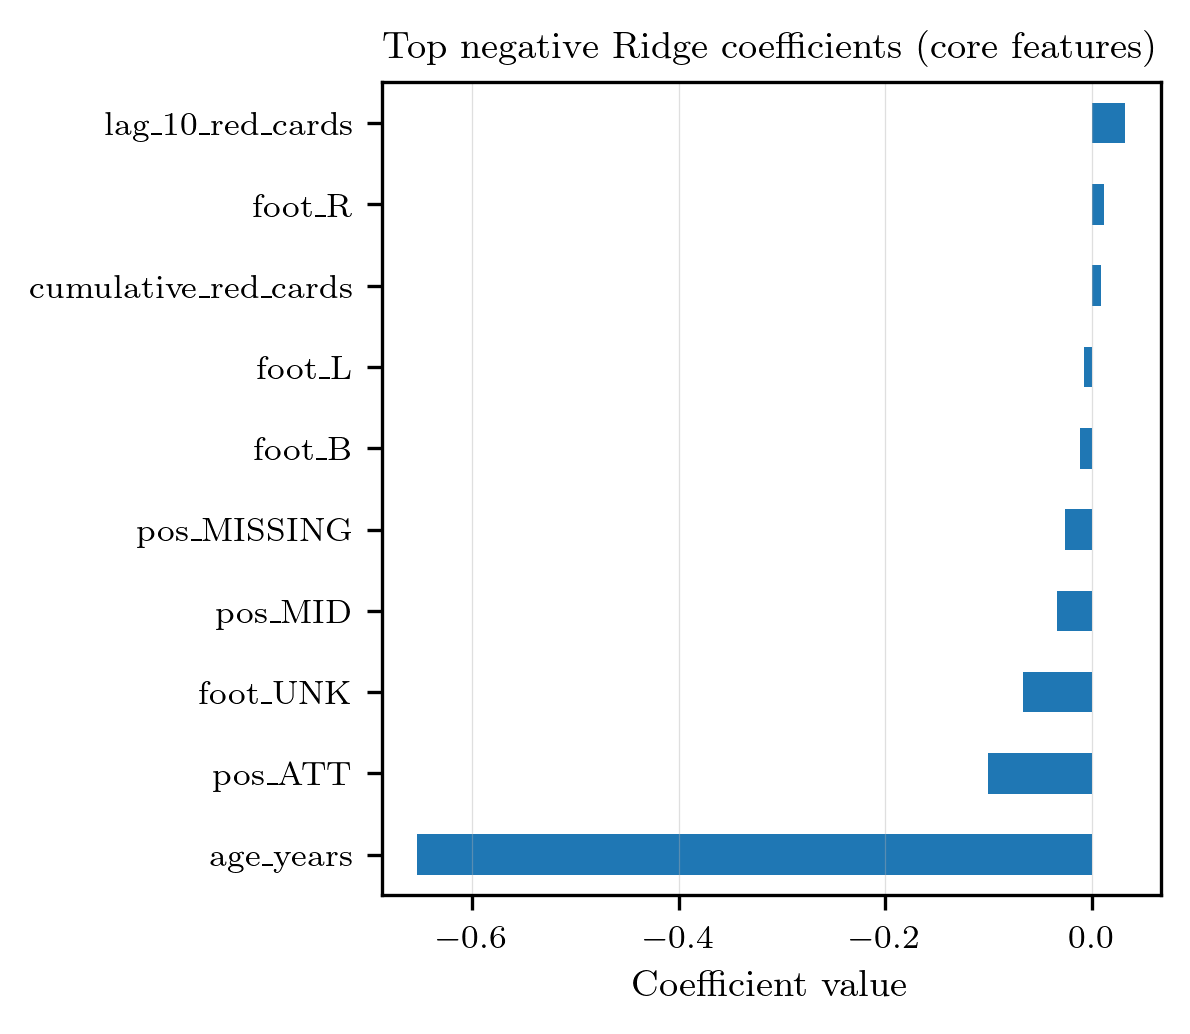

In [12]:
#Style
set_latex_style(usetex=True)

# Collect and sort coefficients 
coef = pd.Series(ridge_best.coef_, index=feature_cols)
coef_sorted = coef.sort_values()


# Top positive coefficients
fig, ax = fig_ax("onecol", height_scale=1.6)

coef_sorted.tail(10).plot(kind="barh", ax=ax)

ax.set_xlabel(r"Coefficient value")
ax.set_title(r"Top positive Ridge coefficients (core features)")
ax.grid(True, axis="x", linewidth=0.3, alpha=0.4)

save_pdf(fig, "fig_ridge_core_top_positive_coefficients.pdf", folder="../Plots")



# Top negative coefficients
fig, ax = fig_ax("onecol", height_scale=1.6)

coef_sorted.head(10).plot(kind="barh", ax=ax)

ax.set_xlabel(r"Coefficient value")
ax.set_title(r"Top negative Ridge coefficients (core features)")
ax.grid(True, axis="x", linewidth=0.3, alpha=0.4)

save_pdf(fig, "fig_ridge_core_top_negative_coefficients.pdf", folder="../Plots")


